# **Setup**

For quicker model training

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

/Users/mmesoma/Desktop/FaceReg/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Install dependencies

In [2]:
#%pip install tensorflow==2.15.1 opencv-python matplotlib

In [3]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

Import dependencies

In [4]:
#Import tensor flow dependencies - Functional API

from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, BatchNormalization
import tensorflow as tf


#Model: Lets you build and train a neural network.
#Layer: The base class for all Keras layers.
#Conv2D: Adds convolutional layers to extract image features.
#Dense: Fully connected layer for making decisions.
#MaxPooling2D: Reduces image size while keeping key features.
#Input: Defines the input shape of the model.
#Flatten: Turns multi-dimensional data into a flat vector.


Set GPU growth

In [5]:
#Avoiding out of memory errors for memory consumption
gpus=tf.config.experimental.list_physical_devices('GPU')

# Enable memory growth for each GPU, so TensorFlow uses memory as needed instead of pre-allocating all at once
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

#  Data collection

Create folder structures

In [6]:
#Setting paths for directories

POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

Collect positive and anchor images 

In [7]:
import uuid

In [8]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/51a04752-fde4-11ef-8b66-a63d57b1cd1f.jpg'

In [9]:
import cv2
import os
import uuid
import time
import numpy as np

# Define paths for saving images
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

# Create directories if they don't exist
for directory in [POS_PATH, NEG_PATH, ANC_PATH]:
    os.makedirs(directory, exist_ok=True)

# Establish a connection to the webcam
cap = cv2.VideoCapture(1)  # Using camera index 1 as you mentioned

# Get the maximum available resolution from your camera
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
print(f"Camera resolution: {width}x{height}")

# Try setting a higher resolution if your camera supports it
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Verify the new resolution
new_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
new_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
print(f"New camera resolution: {new_width}x{new_height}")

# Load face detection cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Variables for automatic capture
auto_capture = False  # Toggle with 'c' key
last_capture_time = 0
capture_interval = 0.5  # Time between captures in seconds
save_as_anchor = True  # Toggle between anchor and positive
num_captured = {'anchor': 0, 'positive': 0}  # Counter for captured images
max_images = 300  # Maximum number of images to capture per class

# Function to save an image
def save_image(frame, save_type):
    global num_captured
    
    if save_type == 'anchor':
        path = ANC_PATH
        num_captured['anchor'] += 1
    else:
        path = POS_PATH
        num_captured['positive'] += 1
        
    imgname = os.path.join(path, f'{uuid.uuid1()}.jpg')
    cv2.imwrite(imgname, frame)
    print(f"Saved {save_type}: {imgname}, size: {frame.shape[:2]}, Total: {num_captured[save_type]}")

# Main loop
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break
    
    # Create a copy for display purposes
    display_frame = frame.copy()
    
    # Face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    # Status text to display
    status_text = f"Auto-capture: {'ON' if auto_capture else 'OFF'} | "
    status_text += f"A: {num_captured['anchor']}, P: {num_captured['positive']}"
    if auto_capture:
        status_text += f" | Next: {'Anchor' if save_as_anchor else 'Positive'}"
    
    if len(faces) > 0:
        # Find the largest face
        face = max(faces, key=lambda rect: rect[2] * rect[3])
        x, y, w, h = face
        
        # Make the crop square and a bit larger than the detected face
        center_x, center_y = x + w//2, y + h//2
        size = max(w, h) * 1.5  # 50% larger than the face
        size = min(size, new_width, new_height)  # Don't exceed frame boundaries
        
        # Calculate crop coordinates
        x1 = max(0, int(center_x - size//2))
        y1 = max(0, int(center_y - size//2))
        x2 = min(int(new_width), int(x1 + size))
        y2 = min(int(new_height), int(y1 + size))
        
        # Draw rectangle for visualization
        cv2.rectangle(display_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Prepare the cropped frame
        cropped_frame = frame[y1:y2, x1:x2]
        
        # Automatic capture logic
        current_time = time.time()
        if auto_capture and (current_time - last_capture_time) > capture_interval:
            # Check if we've reached the maximum number for either class
            if (save_as_anchor and num_captured['anchor'] < max_images) or \
               (not save_as_anchor and num_captured['positive'] < max_images):
                
                # Save the image
                save_type = 'anchor' if save_as_anchor else 'positive'
                save_image(cropped_frame, save_type)
                
                # Toggle between anchor and positive for next capture
                save_as_anchor = not save_as_anchor
                
                # Update last capture time
                last_capture_time = current_time
                
            # Check if we've captured enough of both types
            elif num_captured['anchor'] >= max_images and num_captured['positive'] >= max_images:
                print(f"Maximum images captured: {max_images} anchors and {max_images} positives")
                auto_capture = False
    else:
        # If no face detected, use center crop (simpler fallback)
        center_x, center_y = int(new_width)//2, int(new_height)//2
        size = min(400, int(new_width), int(new_height))  # 400×400 crop or smaller if needed
        
        # Calculate crop coordinates
        x1 = max(0, center_x - size//2)
        y1 = max(0, center_y - size//2)
        x2 = min(int(new_width), x1 + size)
        y2 = min(int(new_height), y1 + size)
        
        # Draw rectangle for visualization
        cv2.rectangle(display_frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        
        # Prepare the cropped frame
        cropped_frame = frame[y1:y2, x1:x2]
    
    # Display status information on screen
    cv2.putText(display_frame, status_text, (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
    
    # Add usage instructions
    instructions = "a: manual anchor | p: manual positive | c: toggle auto-capture | q: quit"
    cv2.putText(display_frame, instructions, (10, int(new_height) - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    # Show both the full frame with rectangle and the cropped version
    cv2.imshow('Full Frame', display_frame)
    
    # Only show the cropped frame if it exists
    if cropped_frame is not None and cropped_frame.size > 0:
        cv2.imshow('Cropped', cropped_frame)
    
    # Handle keyboard input
    key = cv2.waitKey(1) & 0xFF
    
    # Manual capture mode
    if key == ord('a'):
        if len(faces) > 0:  # Only save if a face is detected
            save_image(cropped_frame, 'anchor')
    
    elif key == ord('p'):
        if len(faces) > 0:  # Only save if a face is detected
            save_image(cropped_frame, 'positive')
    
    # Toggle automatic capture
    elif key == ord('c'):
        auto_capture = not auto_capture
        print(f"Auto-capture: {'ON' if auto_capture else 'OFF'}")
        if auto_capture:
            last_capture_time = time.time()  # Reset timer
    
    # Quit
    elif key == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

print(f"Capture session complete:")
print(f"- {num_captured['anchor']} anchor images saved in {ANC_PATH}")
print(f"- {num_captured['positive']} positive images saved in {POS_PATH}")

2025-03-10 19:17:33.979 Python[50915:1448469] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Camera resolution: 1280.0x720.0
New camera resolution: 1280.0x720.0


2025-03-10 19:17:35.830 Python[50915:1448469] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-10 19:17:35.830 Python[50915:1448469] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Capture session complete:
- 0 anchor images saved in data/anchor
- 0 positive images saved in data/positive


Getting our imaage directories as datasets


In [10]:

anchor=tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(200)
positive=tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(200)
negative=tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(200)


In [11]:
# Modify how we create training pairs to ensure equal positive/negative examples
positive_samples = min(len(list(anchor)), len(list(positive)))
negative_samples = positive_samples
anchor = anchor.take(positive_samples)
positive = positive.take(positive_samples)
negative = negative.take(negative_samples)

# Preparing data

PREPROCESS IMAGES

In [12]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    # Add basic image augmentation for better model generalization
    img = tf.image.random_flip_left_right(img)  # Random horizontal flip
    img = tf.image.random_brightness(img, 0.2)   # Slight brightness adjustment
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.image.resize(img, (100, 100))
    # Handle potential numerical instabilities
    img = tf.cast(img, tf.float32) / 255.0
    return img

In [13]:
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

# Combine both positive and negative pairs into a single dataset with a mix of matching and non-matching pairs
raw_data = positives.concatenate(negatives) 

In [14]:
# Calculate split sizes
total_size = len(raw_data)
train_size = round(total_size * 0.7)
val_size = total_size - train_size

In [15]:
val_size

120

In [16]:
raw_data

#The first string is our file path to the specific image, second string is the path to either the positive or neggative image
#last value determines whether its +ve or -ve for verification

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [17]:
sample=raw_data.as_numpy_iterator()

In [18]:
eg=sample.next()

BUILD, TRAIN AND TEST PARTITION 

In [19]:
#Function to preprcess the input and validation images as twins
def preprocess_twins(input_img, validation_img, label):
    try:
        print("Input types:", type(input_img), type(validation_img), type(label))
        print("Input image values:", input_img)
        
        def process_single_image(img):
            # If the image is already a tensor, we need to handle it differently
            if isinstance(img, tf.Tensor):
                # If it's already a preprocessed image tensor
                if img.dtype == tf.float32:
                    return tf.image.resize(img,(100,100))
                # If it's a string tensor (filepath)
                elif img.dtype == tf.string:
                    img = tf.io.read_file(img)
                    img = tf.io.decode_jpeg(img, channels=3)
                    img = tf.cast(img, tf.float32) / 255.0
                    img = tf.image.resize(img, (100, 100))
                    return img
            return None
        
        processed_input = process_single_image(input_img)
        processed_validation = process_single_image(validation_img)
        
        return processed_input, processed_validation, label
    except Exception as e:
        print(f"Error processing images: {str(e)}")
        raise

In [20]:
# Check the first element of the dataset
sample = next(iter(raw_data))
print("Sample structure:", [type(x) for x in sample])
print("First element shape/type:", tf.shape(sample[0]), sample[0].dtype)

Sample structure: [<class 'tensorflow.python.framework.ops.EagerTensor'>, <class 'tensorflow.python.framework.ops.EagerTensor'>, <class 'tensorflow.python.framework.ops.EagerTensor'>]
First element shape/type: tf.Tensor([], shape=(0,), dtype=int32) <dtype: 'string'>


In [21]:
res = preprocess_twins(*eg)  # * collecting the eg values from the register

Input types: <class 'bytes'> <class 'bytes'> <class 'numpy.float32'>
Input image values: b'data/anchor/7fe982e4-fd40-11ef-bd69-a63d57b1cd1f.jpg'


In [22]:
res[1]

In [23]:
res[2]

1.0

# Building siamese network

Build dataloader pipeline

In [24]:
def build_data_pipeline(data, batch_size=32, training=True):
    """
    Creates an optimized data pipeline that properly handles caching.
    The order of operations is crucial for efficient data processing.
    """
    # First preprocess the raw images
    data = data.map(preprocess_twins, num_parallel_calls=tf.data.AUTOTUNE)
    
    if training:
        # For training data, shuffle before batching
        data = data.shuffle(1000)
    
    # Batch the data
    data = data.batch(batch_size, drop_remainder=True)
    
    # Cache after batching to store complete batches
    data = data.cache()
    
    # Prefetch at the end for pipeline efficiency
    data = data.prefetch(tf.data.AUTOTUNE)
    
    return data


Training partition

In [25]:
# Verify the shapes
def verify_shapes(dataset, name):
    print(f"\nVerifying {name} shapes:")
    for batch in dataset.take(1):
        print(f"Input shape: {batch[0].shape}")
        print(f"Validation shape: {batch[1].shape}")
        print(f"Label shape: {batch[2].shape}")
        break



In [26]:
# Create and verify datasets with monitoring
def create_and_verify_datasets(raw_data, batch_size=32):
    # Calculate split sizes
    total_size = len(raw_data)
    train_size = round(total_size * 0.7)
    
    # Split raw data
    raw_train = raw_data.take(train_size)
    raw_val = raw_data.skip(train_size)
    
    # Create pipelines
    train_data = build_data_pipeline(raw_train, batch_size, training=True)
    val_data = build_data_pipeline(raw_val, batch_size, training=False)
    
    # Verify both datasets
    print("\nDataset Statistics:")
    print(f"Total examples: {total_size}")
    print(f"Training examples: {train_size}")
    print(f"Validation examples: {total_size - train_size}")
    
    return train_data, val_data



In [27]:
# Use the improved creation function
train_data, val_data = create_and_verify_datasets(raw_data)

Input types: <class 'tensorflow.python.framework.ops.SymbolicTensor'> <class 'tensorflow.python.framework.ops.SymbolicTensor'> <class 'tensorflow.python.framework.ops.SymbolicTensor'>
Input image values: Tensor("args_0:0", shape=(), dtype=string)
Input types: <class 'tensorflow.python.framework.ops.SymbolicTensor'> <class 'tensorflow.python.framework.ops.SymbolicTensor'> <class 'tensorflow.python.framework.ops.SymbolicTensor'>
Input image values: Tensor("args_0:0", shape=(), dtype=string)

Dataset Statistics:
Total examples: 400
Training examples: 280
Validation examples: 120


In [28]:
# Check both datasets
verify_shapes(train_data, "Training Data")
verify_shapes(val_data, "Validation Data")


Verifying Training Data shapes:
Input shape: (32, 100, 100, 3)
Validation shape: (32, 100, 100, 3)
Label shape: (32,)

Verifying Validation Data shapes:
Input shape: (32, 100, 100, 3)
Validation shape: (32, 100, 100, 3)
Label shape: (32,)


2025-03-10 19:17:42.819823: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-10 19:17:42.861974: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [29]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32,), dtype=tf.float32, name=None))>

In [30]:
train_sample = train_data.as_numpy_iterator()

In [31]:
train_sample =train_sample.next()

2025-03-10 19:17:43.072793: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [32]:
len(train_sample[0])

32

MODEL ENGINEERING

In [33]:

#https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf  Siememse networks paper

#Builds embedding layer

def make_embedding():
    inp=Input(shape=(100,100,3), name='input_image')

    #First block 
    c1 = Conv2D(64, (10,10), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inp)
    c1 = BatchNormalization()(c1)
    m1 = MaxPooling2D(64,(2,2),padding='same')(c1)
    m1 = tf.keras.layers.Dropout(0.3)(m1)

    #Second block
    c2 = Conv2D(128, (3,3), activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2),padding='same')(c2)
    m2 = tf.keras.layers.Dropout(0.3)(m2)

    #Third block 
    c3 = Conv2D(128, (7,7), activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2),padding='same')(c3)
    m3 = tf.keras.layers.Dropout(0.3)(m3)

    #Fouth block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [34]:
embedding = make_embedding()

In [35]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 batch_normalization (Batch  (None, 91, 91, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 46, 46, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 128)       73

Build distance layer

In [36]:
class L1Dist(Layer):

    #Init method for inheritance
    def __init__(self, **kwargs):
        super().__init__()

    #Des the similarity calculation 
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding) + 1e-6

In [37]:
l1 = L1Dist()

Make Siamese model

In [38]:
def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    #Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    #Combine siamese distance components
    siamise_layer = L1Dist()
    siamise_layer._name = 'distance'
    distances = siamise_layer(embedding(input_image), embedding(validation_image))

    #Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')



In [39]:
siamese_model = make_siamese_model()

In [40]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 2763936   ['input_img[0][0]',           
                                                          0          'validation_img[0][0]']      
                                                                                     

# Training Siamese Network

Setup loss function and optimizer

In [41]:
loss_function = tf.losses.BinaryCrossentropy()

initial_learning_rate = 5e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=200,
    decay_rate=0.97
)


In [42]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule) #learning rate @ 0.0001 initially then gradually reduces

Make a ckeckpoint 

In [43]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [44]:
# Add before training
import shutil
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)
os.makedirs(checkpoint_dir, exist_ok=True)

Build train step function

In [45]:
test_batch = train_data.as_numpy_iterator()

In [46]:
batch1 = test_batch.next()

In [47]:
batch1[2]

array([1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

In [48]:
@tf.function
def train_step(batch):
    # Get anchor and positive/negative images
    X = batch[:2]
    # Get label
    Y = batch[2]
    
    # Record operations with gradient tape
    with tf.GradientTape() as tape:
        # Forward pass through the model
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = loss_function(Y, yhat)
    
    # Calculate gradients
    gradients = tape.gradient(loss, siamese_model.trainable_variables)
    # Clip gradients to prevent exploding gradients
    clipped_gradients = [tf.clip_by_value(g, -1.0, 1.0) for g in gradients]
    # Apply gradients to update model
    opt.apply_gradients(zip(clipped_gradients, siamese_model.trainable_variables))
    
    return loss

Build training loop

In [49]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1): 
        print(f'\nEpoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Track losses for this epoch
        epoch_loss = tf.keras.metrics.Mean()
        
        for idx, batch in enumerate(data):
            # Get numerical loss value
            loss = train_step(batch)
            epoch_loss.update_state(loss)
            
            # Update progress bar with actual loss value
            progbar.update(
                idx+1, 
                values=[('loss', float(epoch_loss.result()))]
            )
            
        # Save checkpoints every 10 epochs
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

Train the model

In [50]:
EPOCHS = 50

In [51]:
# Check data shape
for batch in train_data.take(1):
    print("Input shape:", batch[0].shape)
    print("Validation shape:", batch[1].shape)
    print("Label shape:", batch[2].shape)
    break

# Check model input shape
print("\nModel input shape:")
for layer in siamese_model.layers:
    if isinstance(layer, tf.keras.layers.InputLayer):
        print(f"{layer.name}: {layer.input_shape}")

Input shape: (32, 100, 100, 3)
Validation shape: (32, 100, 100, 3)
Label shape: (32,)

Model input shape:
input_img: [(None, 100, 100, 3)]
validation_img: [(None, 100, 100, 3)]


2025-03-10 19:17:43.794131: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [52]:
# Initialize model by running one batch through it
for batch in train_data.take(1):
    X = batch[:2]
    # Do a forward pass to initialize variables
    _ = siamese_model(X, training=False)

2025-03-10 19:17:44.005954: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [54]:
train(train_data, EPOCHS)



Epoch 1/50
8/8 [==============================] - 53s 7s/step - loss: 0.6422

Epoch 2/50
8/8 [==============================] - 57s 7s/step - loss: 0.6353

Epoch 3/50
8/8 [==============================] - 53s 7s/step - loss: 0.6026

Epoch 4/50
8/8 [==============================] - 54s 7s/step - loss: 0.5760

Epoch 5/50
8/8 [==============================] - 50s 6s/step - loss: 0.5742

Epoch 6/50
8/8 [==============================] - 51s 6s/step - loss: 0.4979

Epoch 7/50
8/8 [==============================] - 50s 6s/step - loss: 0.4069

Epoch 8/50
8/8 [==============================] - 50s 6s/step - loss: 0.2872

Epoch 9/50
8/8 [==============================] - 52s 7s/step - loss: 0.1784

Epoch 10/50
8/8 [==============================] - 51s 6s/step - loss: 0.1072

Epoch 11/50
8/8 [==============================] - 52s 7s/step - loss: 0.0601

Epoch 12/50
8/8 [==============================] - 51s 6s/step - loss: 0.0447

Epoch 13/50
8/8 [==============================] - 50s 6s/st

EVALUATE MODEL

In [113]:
from tensorflow.keras.metrics import Precision, Recall


In [114]:
test_data = raw_data.skip(train_size)
test_data = test_data.map(preprocess_twins)
test_data = test_data.batch(32)
test_data = test_data.prefetch(tf.data.AUTOTUNE)
# Create a balanced test dataset with both positive and negative examples
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

# Combine and shuffle
balanced_data = positives.concatenate(negatives).shuffle(buffer_size=1000)

# Split into train/test
total_size = len(balanced_data)
train_size = round(total_size * 0.7)

train_data = balanced_data.take(train_size)
test_data = balanced_data.skip(train_size)

# Process for the model
train_data = train_data.map(preprocess_twins).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_twins).batch(32).prefetch(tf.data.AUTOTUNE)

Input types: <class 'tensorflow.python.framework.ops.SymbolicTensor'> <class 'tensorflow.python.framework.ops.SymbolicTensor'> <class 'tensorflow.python.framework.ops.SymbolicTensor'>
Input image values: Tensor("args_0:0", shape=(), dtype=string)
Input types: <class 'tensorflow.python.framework.ops.SymbolicTensor'> <class 'tensorflow.python.framework.ops.SymbolicTensor'> <class 'tensorflow.python.framework.ops.SymbolicTensor'>
Input image values: Tensor("args_0:0", shape=(), dtype=string)
Input types: <class 'tensorflow.python.framework.ops.SymbolicTensor'> <class 'tensorflow.python.framework.ops.SymbolicTensor'> <class 'tensorflow.python.framework.ops.SymbolicTensor'>
Input image values: Tensor("args_0:0", shape=(), dtype=string)


In [115]:
def evaluate_model(model, test_data):
    # Initialize metrics
    precision_metric = Precision()
    recall_metric = Recall()
    
    print("Evaluating model on test data...")
    for batch in test_data:
        # Get inputs and labels
        X = batch[:2]
        y = batch[2]
        
        # Generate predictions
        y_pred = model(X, training=False)
        
        # Update metrics
        precision_metric.update_state(y, y_pred)
        recall_metric.update_state(y, y_pred)
    
    # Get metric results
    precision = precision_metric.result().numpy()
    recall = recall_metric.result().numpy()
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print("\n===== Model Evaluation =====")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    
    return precision, recall, f1_score

In [116]:
def analyze_thresholds(model, test_data):
    all_preds = []
    all_labels = []
    
    for batch in test_data:
        X = batch[:2]
        y = batch[2].numpy()
        y_pred = model(X, training=False).numpy().flatten()
        
        all_preds.extend(y_pred)
        all_labels.extend(y)
    
    # Test different thresholds
    thresholds = np.arange(0, 0.5, 0.02)
    f1_scores = []
    
    for threshold in thresholds:
        binary_preds = (np.array(all_preds) > threshold).astype(int)
        
        # Calculate metrics
        tp = np.sum((binary_preds == 1) & (np.array(all_labels) == 1))
        fp = np.sum((binary_preds == 1) & (np.array(all_labels) == 0))
        fn = np.sum((binary_preds == 0) & (np.array(all_labels) == 1))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        f1_scores.append(f1)
    
    # Find best threshold
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    
    print(f"Optimal threshold: {best_threshold:.4f} with F1: {f1_scores[best_idx]:.4f}")
    return best_threshold

In [117]:
def evaluate_with_threshold(model, test_data, threshold):
    all_preds = []
    all_labels = []
    
    for batch in test_data:
        X = batch[:2]
        y = batch[2].numpy()
        y_pred = model(X, training=False).numpy().flatten()
        
        all_preds.extend(y_pred)
        all_labels.extend(y)
    
    # Apply threshold
    binary_preds = (np.array(all_preds) > threshold).astype(int)
    
    # Calculate metrics
    tp = np.sum((binary_preds == 1) & (np.array(all_labels) == 1))
    fp = np.sum((binary_preds == 1) & (np.array(all_labels) == 0))
    fn = np.sum((binary_preds == 0) & (np.array(all_labels) == 1))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"With threshold {threshold:.4f}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return precision, recall, f1

In [118]:
precision, recall, f1_score = evaluate_model(siamese_model, test_data)


Evaluating model on test data...

===== Model Evaluation =====
Precision: 1.0000
Recall: 0.1930
F1 Score: 0.3235


In [119]:
best_threshold = analyze_thresholds(siamese_model, test_data)


Optimal threshold: 0.1200 with F1: 0.9912


In [120]:
precision, recall, f1 = evaluate_with_threshold(siamese_model, test_data, best_threshold)


With threshold 0.1200:
Precision: 0.9796
Recall: 0.9600
F1 Score: 0.9697


Visualise results

In [123]:
def visualize_results(model, test_data, threshold=0.5, num_examples=5):
    """
    Visualize prediction results from the Siamese model
    
    Args:
        model: The trained Siamese model
        test_data: The test dataset
        threshold: Decision threshold for positive/negative classification
        num_examples: Number of examples to visualize
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Get a batch of data
    test_batch = next(test_data.as_numpy_iterator())
    X = test_batch[:2]  # Input images
    y_true = test_batch[2]  # True labels
    
    # Generate predictions
    y_pred = model(X, training=False).numpy().flatten()
    
    # Limit to the number of examples requested
    n = min(num_examples, len(y_true))
    
    for i in range(n):
        # Set up the figure
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        
        # Display the image pair
        axes[0].imshow(X[0][i])
        axes[0].set_title('Anchor Image')
        axes[0].axis('off')
        
        axes[1].imshow(X[1][i])
        
        # Determine match status and correctness
        is_match = y_true[i] > 0.5
        predicted_match = y_pred[i] > threshold
        is_correct = (is_match == predicted_match)
        
        # Create detailed title
        title = f"{'Match' if is_match else 'No Match'} (Ground Truth)\n"
        title += f"Prediction: {'Match' if predicted_match else 'No Match'}\n"
        title += f"Confidence: {y_pred[i]:.4f}, Threshold: {threshold:.2f}"
        
        # Set the title color based on match/no-match, not correctness
        color = 'green' if is_match else 'red'
        
        axes[1].set_title(title, color=color)
        axes[1].axis('off')
        
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)  # Make room for the text
        plt.show()

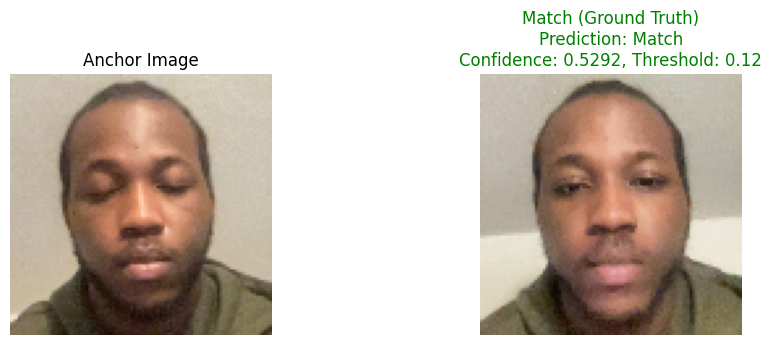

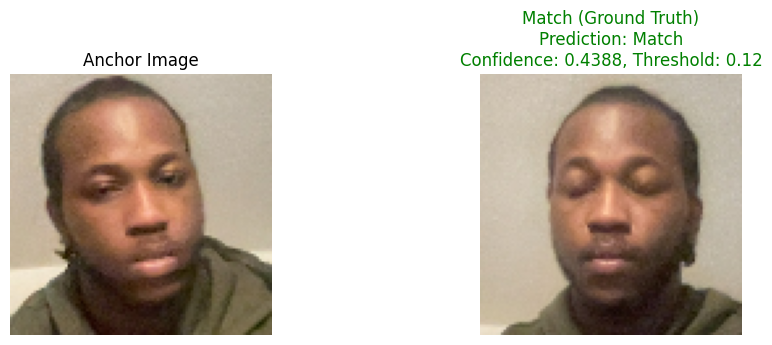

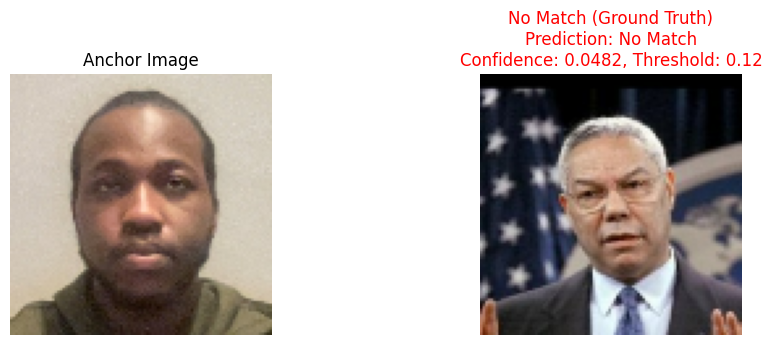

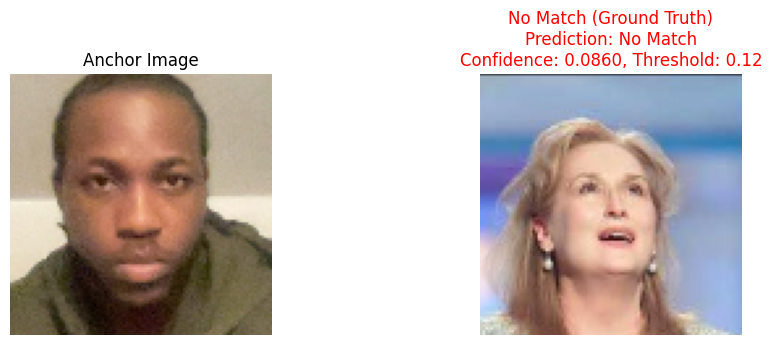

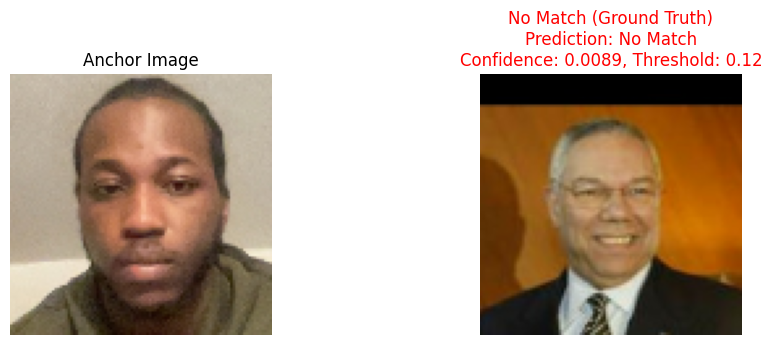

In [124]:
visualize_results(siamese_model, test_data, threshold=best_threshold)


In [125]:
def visualize_threshold_analysis(model, test_data):
    """
    Visualize the impact of different thresholds on model performance
    
    Args:
        model: The trained Siamese model
        test_data: The test dataset
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Collect all predictions
    all_preds = []
    all_labels = []
    
    for batch in test_data:
        X = batch[:2]
        y = batch[2].numpy()
        y_pred = model(X, training=False).numpy().flatten()
        
        all_preds.extend(y_pred)
        all_labels.extend(y)
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Compute metrics at different thresholds
    thresholds = np.arange(0, 1.01, 0.05)
    precisions = []
    recalls = []
    f1_scores = []
    
    for threshold in thresholds:
        binary_preds = (all_preds > threshold).astype(int)
        
        # Calculate metrics
        tp = np.sum((binary_preds == 1) & (all_labels == 1))
        fp = np.sum((binary_preds == 1) & (all_labels == 0))
        fn = np.sum((binary_preds == 0) & (all_labels == 1))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
    # Find optimal threshold
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    
    # Plot metrics vs threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, 'b-', label='Precision')
    plt.plot(thresholds, recalls, 'g-', label='Recall')
    plt.plot(thresholds, f1_scores, 'r-', label='F1 Score')
    
    # Mark the optimal threshold
    plt.axvline(x=best_threshold, color='k', linestyle='--', 
                label=f'Best Threshold = {best_threshold:.2f}')
    
    plt.title('Model Performance vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot prediction distribution
    plt.figure(figsize=(10, 6))
    
    # Separate predictions for positive and negative pairs
    pos_preds = all_preds[all_labels == 1]
    neg_preds = all_preds[all_labels == 0]
    
    # Plot histograms
    plt.hist(pos_preds, bins=20, alpha=0.6, color='green', label='Matching Pairs')
    plt.hist(neg_preds, bins=20, alpha=0.6, color='red', label='Non-matching Pairs')
    
    plt.axvline(x=best_threshold, color='k', linestyle='--', 
                label=f'Best Threshold = {best_threshold:.2f}')
    
    plt.title('Distribution of Similarity Scores')
    plt.xlabel('Model Prediction (Similarity Score)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


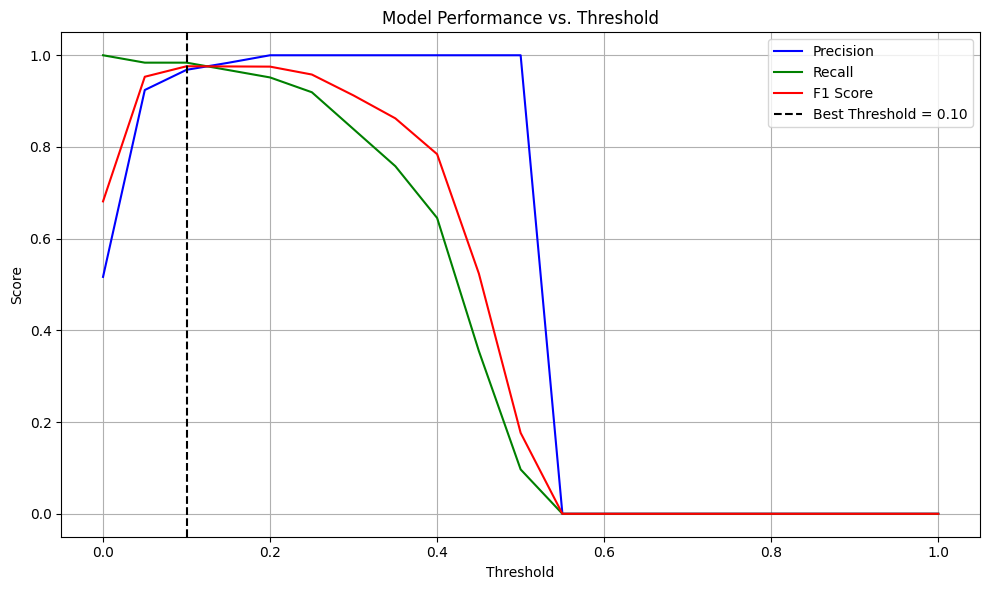

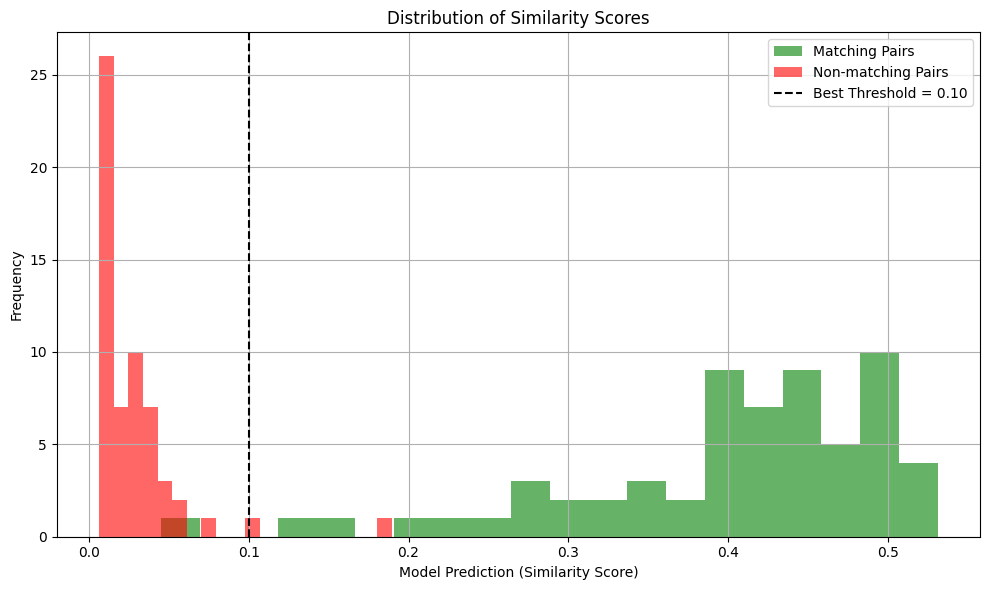

In [126]:
visualize_threshold_analysis(siamese_model, test_data)


In [127]:
def save_model(model, embedding_model, best_threshold, model_metrics, version=None):
    """
    Save the Siamese model with metadata
    
    Args:
        model: The trained Siamese model
        embedding_model: The embedding part of the model
        best_threshold: The optimal threshold for classification
        model_metrics: Dictionary with precision, recall, and f1_score
        version: Optional version string (defaults to timestamp)
    """
    import os
    import time
    import json
    import tensorflow as tf
    
    # Create directories
    base_dir = 'models'
    os.makedirs(base_dir, exist_ok=True)
    
    # Create version name with timestamp if not provided
    if not version:
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        version = f"siamese_model_{timestamp}"
    
    # Create model directory
    model_dir = os.path.join(base_dir, version)
    os.makedirs(model_dir, exist_ok=True)
    
    # 1. Save full model
    full_model_path = os.path.join(model_dir, 'full_model')
    model.save(full_model_path)
    print(f"Full model saved to: {full_model_path}")
    
    # 2. Save embedding model
    embedding_path = os.path.join(model_dir, 'embedding')
    embedding_model.save(embedding_path)
    print(f"Embedding model saved to: {embedding_path}")
    
    # 3. Save model weights
    weights_path = os.path.join(model_dir, 'model_weights.h5')
    model.save_weights(weights_path)
    print(f"Model weights saved to: {weights_path}")
    
    # 4. Save model metadata
    metadata = {
        'model_name': version,
        'date_created': time.strftime("%Y-%m-%d %H:%M:%S"),
        'framework_version': tf.__version__,
        'image_size': [100, 100, 3],
        'metrics': {
            'precision': float(model_metrics['precision']),
            'recall': float(model_metrics['recall']),
            'f1_score': float(model_metrics['f1_score'])
        },
        'optimal_threshold': float(best_threshold),
    }
    
    metadata_path = os.path.join(model_dir, 'model_info.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"Model metadata saved to: {metadata_path}")
    
    # 5. Create usage example file
    example_code = f"""# Example code to use the Siamese face verification model

import tensorflow as tf
import cv2
import numpy as np

# Define L1Dist layer (needed for model loading)
class L1Dist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# Load the saved model
model_path = '{full_model_path}'
model = tf.keras.models.load_model(
    model_path, 
    custom_objects={{'L1Dist': L1Dist}}
)

def preprocess_image(img_path):
    # Read image
    img = cv2.imread(img_path)
    # Resize to model input size
    img = cv2.resize(img, (100, 100))
    # Normalize pixel values
    img = img / 255.0
    return img

def verify_faces(img_path1, img_path2, threshold={best_threshold}):
    # Preprocess images
    img1 = preprocess_image(img_path1)
    img2 = preprocess_image(img_path2)
    
    # Add batch dimension
    img1 = np.expand_dims(img1, axis=0)
    img2 = np.expand_dims(img2, axis=0)
    
    # Get prediction
    result = model.predict([img1, img2])
    similarity_score = result[0][0]
    
    # Determine if match based on optimal threshold
    is_match = similarity_score > threshold
    
    return {{'is_match': bool(is_match), 'score': float(similarity_score)}}

# Example usage
# result = verify_faces('person1.jpg', 'person2.jpg')
# print(f"Match: {{result['is_match']}}, Score: {{result['score']:.4f}}")
"""
    
    example_path = os.path.join(model_dir, 'usage_example.py')
    with open(example_path, 'w') as f:
        f.write(example_code)
    print(f"Usage example saved to: {example_path}")
    
    print(f"\nModel successfully saved to {model_dir}")
    return model_dir


# Example usage:
# model_metrics = {
#     'precision': precision,
#     'recall': recall, 
#     'f1_score': f1_score
# }
# 
# saved_dir = save_model(
#     model=siamese_model,
#     embedding_model=embedding,
#     best_threshold=best_threshold,
#     model_metrics=model_metrics
# )

In [128]:
model_metrics = {
    'precision': precision,
    'recall': recall, 
    'f1_score': f1_score
}

saved_dir = save_model(
    model=siamese_model,
    embedding_model=embedding,
    best_threshold=best_threshold,
    model_metrics=model_metrics
)

INFO:tensorflow:Assets written to: models/siamese_model_20250310_225116/full_model/assets


INFO:tensorflow:Assets written to: models/siamese_model_20250310_225116/full_model/assets


Full model saved to: models/siamese_model_20250310_225116/full_model


INFO:tensorflow:Assets written to: models/siamese_model_20250310_225116/embedding/assets


INFO:tensorflow:Assets written to: models/siamese_model_20250310_225116/embedding/assets


Embedding model saved to: models/siamese_model_20250310_225116/embedding
Model weights saved to: models/siamese_model_20250310_225116/model_weights.h5
Model metadata saved to: models/siamese_model_20250310_225116/model_info.json
Usage example saved to: models/siamese_model_20250310_225116/usage_example.py

Model successfully saved to models/siamese_model_20250310_225116
